# Imports and Data Loading

In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Union, Sequence, Tuple

home = os.getcwd()
current = home
while 'models' not in os.listdir(current):
    current = Path(current).parent

sys.path.append(str(current))

DATA_FOLDER = os.path.join(Path(os.getcwd()).parent, 'data')
print(DATA_FOLDER)

/home/ayhem18/DEV/RecSys/data


In [2]:
# read the prepared 'items' and 'users' data
users_path = os.path.join(DATA_FOLDER, 'prepared', 'users.csv')
items_path = os.path.join(DATA_FOLDER, 'prepared', 'items.csv')
users = pd.read_csv(users_path)
items = pd.read_csv(items_path)
ratings = pd.read_csv(os.path.join(DATA_FOLDER, 'ml-100k', 'ua.base'), sep='\t', encoding='latin', header=None).rename(columns={0: 'user_id', 1: 'item_id', 2: 'rating', 3: 'time'})


In [3]:
# let's group all the data together
all_data = pd.merge(left=users, right=ratings, right_on='user_id', left_on='id').drop(columns=['id'])
all_data = pd.merge(left=all_data, right=items, left_on='item_id', right_on='id').drop(columns=['id'])
all_data.head()

,age,gender,job,user_id,item_id,rating,time,unknown,Action,Adventure,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,-0.824859,1,technician,1,1,5,874965758,0,0,0,...,0,0,0,0,0,0,0,0,0,0.95
1,1.554867,0,other,2,1,4,888550871,0,0,0,...,0,0,0,0,0,0,0,0,0,0.95
2,0.652212,1,executive,6,1,4,883599478,0,0,0,...,0,0,0,0,0,0,0,0,0,0.95
3,1.554867,1,lawyer,10,1,4,877888877,0,0,0,...,0,0,0,0,0,0,0,0,0,0.95
4,1.062510,1,educator,13,1,3,882140487,0,0,0,...,0,0,0,0,0,0,0,0,0,0.95


# What can the ratings tell us ?

In [4]:
import visualization.visual as vis
import importlib
importlib.reload(vis)

<module 'visualization.visual' from '/home/ayhem18/DEV/RecSys/visualization/visual.py'>

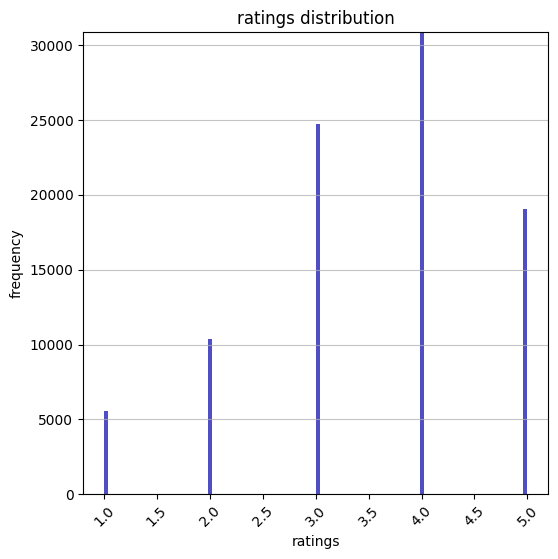

In [5]:
ratings = all_data['rating']
vis.plot_histogram(x=ratings, x_label='ratings', y_label='frequency', title='ratings distribution', fig_size=(6, 6))

it seems that our users are pretty generous (or we have a good databse of movies). 

Let's try to understand the variance of the ratings per movie

In [6]:
from scipy.stats import iqr

num_df = all_data.select_dtypes(include='number')
# let's calculate the variance, count and mean of ratings per movie
stats_per_movie = pd.pivot_table(data=num_df, index='item_id', values='rating', aggfunc=['mean', 'std', 'count', 'median', iqr])
stats_per_movie.columns = ['mean', 'std', 'count', 'median', 'iqr']
# sort them by the number of ratings
stats_per_movie = stats_per_movie.fillna(value=0).sort_values(by='count', ascending=False)

# let's consider only movies with at least 10 ratings
stats_per_movie = stats_per_movie[stats_per_movie['count'] >= 10]
stats_per_movie.head()

,mean,std,count,median,iqr
item_id,,,,,
50,4.365657,0.877999,495,5.0,1.0
100,4.148984,0.965663,443,4.0,1.0
181,4.011390,0.915298,439,4.0,1.0
258,3.791262,1.006123,412,4.0,2.0
286,3.692500,1.147273,400,4.0,2.0


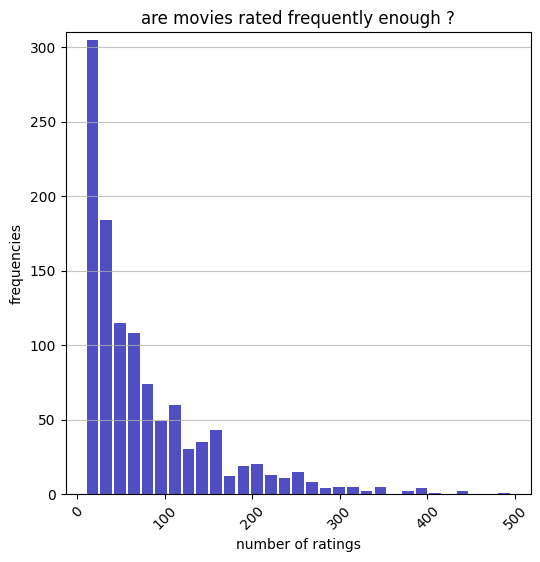

In [7]:
vis.plot_histogram(x=stats_per_movie['count'], 
                   x_label='number of ratings', 
                   y_label='frequencies', 
                   title='are movies rated frequently enough ?', 
                   fig_size=(6, 6))

As we can see, many of the movies have very low number of ratings. Such skewed distribution will evidently present an obstance towards reliable predictions. 

Let's look into this in more depth.

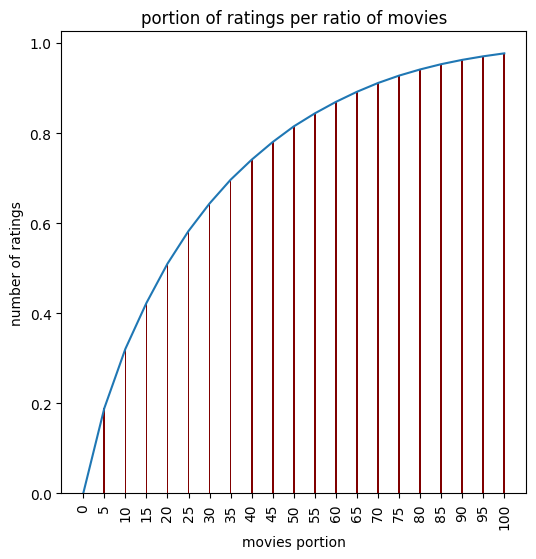

In [8]:
ratios = []
for i in np.linspace(0, 1, 21):
    num_movies = int(len(stats_per_movie) * i)
    num_ratings = sum(stats_per_movie.iloc[:num_movies, :]['count'])
    num_all_ratings = len(ratings)
    ratios.append(round(num_ratings / num_all_ratings, 6))

vis.bar_plot(x=(np.linspace(0, 1, 21) * 100).astype(np.int32), y=ratios, x_label='movies portion', 
             y_label='number of ratings', 
             title='portion of ratings per ratio of movies', 
             fig_size=(6, 6), xticks=np.linspace(0, 1, 21) * 100, show=False)

plt.plot((np.linspace(0, 1, 21) * 100).astype(np.int32), ratios)

We can see that the top $5\%$ movies are associated with $20\%$ of the ratings which reflets the skewness of the data.

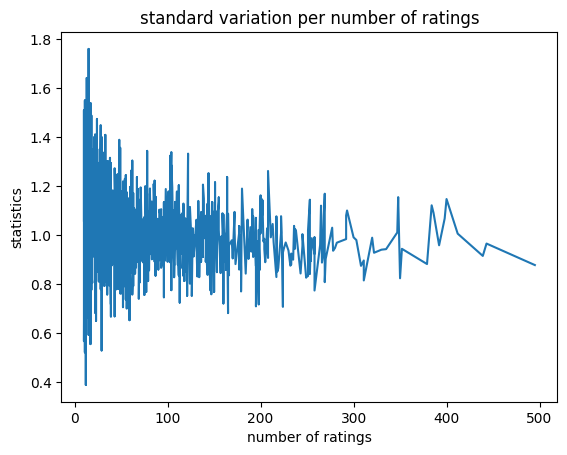

In [9]:
# how is the  affected by the total number of ratings
m_count = stats_per_movie['count']
m_avg = stats_per_movie['mean']
m_std = stats_per_movie['std']
m_med = stats_per_movie['median']
m_iqr = stats_per_movie['iqr']
# let's see how these values 

plt.plot(m_count, m_std)
plt.title('standard variation per number of ratings')
plt.xlabel('number of ratings')
plt.ylabel('statistics')
# plt.legend()
plt.show()


As we can see the standard variation is quite high mainly for movies with few ratings.

but what about users ?

In [12]:
stats_per_user = pd.pivot_table(data=num_df, index='user_id', values='rating', aggfunc=['mean', 'std', 'count', 'median'])

stats_per_user.columns = ['mean', 'std', 'count', 'median']
# sort them by the number of ratings
stats_per_user = stats_per_user.fillna(value=0).sort_values(by='count', ascending=False)

stats_per_user.head()

,mean,std,count,median
user_id,,,,
405,1.839065,1.348487,727,1.0
655,2.909630,0.734370,675,3.0
13,3.089457,1.420417,626,3.0
450,3.860377,0.862655,530,4.0
276,3.474409,1.019211,508,4.0


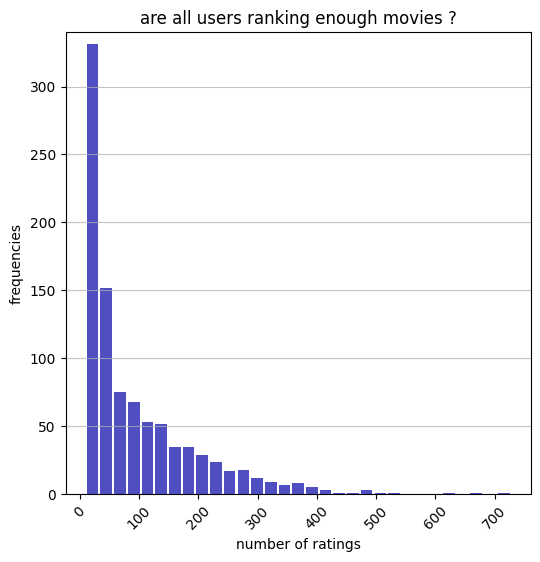

In [13]:
vis.plot_histogram(x=stats_per_user['count'], 
                   x_label='number of ratings', 
                   y_label='frequencies', 
                   title='are all users ranking enough movies ?', 
                   fig_size=(6, 6))

it seems that most users have very few rankings...

# 2 Time columns: what about their difference ?

The difference between the rating time and the release year might be relevant for prediction.


In [9]:
# let's prepare the data
import datetime
all_data['rating_date'] = all_data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x)) 
all_data['rating_date'] = pd.to_datetime(all_data['rating_date'])
all_data['rating_year'] = all_data['rating_date'].apply(lambda x: x.year)

In [10]:
all_data[['rating_date', 'rating_year']]
def time_diff(row):
    row['time_diff'] = max(row['rating_year'] - row['year'], 0) 
    return row
all_data = all_data.apply(time_diff, axis=1)

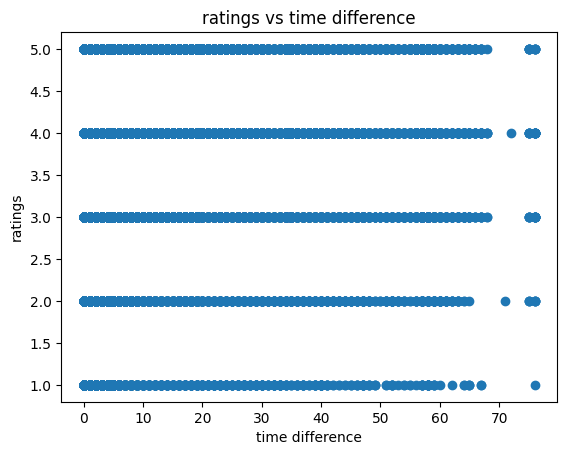

In [11]:
plt.scatter(x=all_data['time_diff'], 
            y=all_data['rating'])
plt.xlabel('time difference')
plt.ylabel('ratings')
plt.title('ratings vs time difference')
plt.show()

In [12]:
# let's try to measure the correlation between the time difference and the ratings
all_data[['time_diff', 'rating']].corr()

,time_diff,rating
time_diff,1.000000,0.172903
rating,0.172903,1.000000


In [13]:
all_data['time_diff'] = all_data['time_diff'] // 10
all_data.pivot_table(index='time_diff', values='rating', aggfunc=['mean', 'median', 'count', 'std'])    

,mean,median,count,std
,rating,rating,rating,rating
time_diff,,,,
0,3.401280,4.0,65919,1.140587
1,3.744579,4.0,9823,1.054229
2,3.893498,4.0,5014,1.046222
3,3.913878,4.0,3646,0.972454
4,3.929913,4.0,2768,0.926345
5,3.998459,4.0,2596,0.944713
6,3.890667,4.0,750,0.925124
7,3.574074,4.0,54,1.038901


The 3 results above present enough evidence that the difference between the movie release data and the rating data is unlikely to be significant.

# Target Encoding for the 'job' column:

Even though it might be possible to use label encoding to encode the state and job columns, Label encoding is far from the optimal for of encoding as it indirectly imposes an order on non ordinal data. 

We can embed more information about target by using Target Encoding, a technique where categorical columns are substituted with an expression including both the field and an aggregation of the target variable.

In [14]:
genres = [
"Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western"
]

In [15]:
# let's first consider only the columns we need: 
fields = ['rating', 'job'] + genres 
df_reduced = all_data[fields]
df_reduced.head()

,rating,job,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5,technician,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,other,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,executive,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,lawyer,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,educator,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
def multiply_genre_per_rating(row):
    for c in genres:
        row[c] = row['rating'] * row[c]
    return row

# the binary genre one hot vector is not multiplied by the rating associated it with it. 
df_reduced_with_ratings = df_reduced.apply(multiply_genre_per_rating, axis=1)
df_reduced_with_ratings.head()

,rating,job,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5,technician,0,0,5,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,other,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,executive,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,lawyer,0,0,4,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,educator,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
genre_rating_per_job = df_reduced_with_ratings.groupby('job').agg(func='sum')
genre_rating_per_job.shape

(21, 19)

In [27]:
# calculate the movies per genre and per job
genre_per_job = df_reduced.groupby('job').agg(func='sum')
genre_per_job.shape

(21, 19)

In [33]:
# we can now calculate the average rate per job for each genre
# simply by dividing
genre_job_emb = (genre_rating_per_job / genre_per_job).fillna(0)

In [36]:
# let's see if our built representations are indeed discriminative
job_embeddings_diffs = np.zeros(shape=(21, 21))
for i1, job1 in enumerate(genre_job_emb.index):
    for i2, job2 in enumerate(genre_job_emb.index):
        e1, e2 = genre_job_emb.loc[job1].values, genre_job_emb.loc[job2].values
        # compute the cosine difference between the representation of the first and second job        
        job_embeddings_diffs[i1, i2] = np.dot((e1 / np.linalg.norm(e1)), (e2 / np.linalg.norm(e2)))

job_embeddings_diffs = pd.DataFrame(data=job_embeddings_diffs, index=genre_job_emb.index, columns=list(genre_job_emb.index))
job_embeddings_diffs

,administrator,artist,doctor,educator,engineer,entertainment,executive,healthcare,homemaker,lawyer,...,marketing,none,other,programmer,retired,salesman,scientist,student,technician,writer
job,,,,,,,,,,,,,,,,,,,,,
administrator,1.000000,0.999278,0.998418,0.999626,0.999806,0.999383,0.993596,0.997518,0.962875,0.998701,...,0.999148,0.997800,0.999889,0.999846,0.999426,0.997205,0.999566,0.999762,0.999545,0.999570
artist,0.999278,1.000000,0.998473,0.998973,0.999224,0.999469,0.991948,0.995663,0.961005,0.999031,...,0.999230,0.995814,0.998978,0.999207,0.998721,0.997486,0.999497,0.999402,0.999566,0.999144
doctor,0.998418,0.998473,1.000000,0.998513,0.999073,0.998051,0.996145,0.997628,0.962873,0.998781,...,0.998855,0.995318,0.998341,0.998606,0.998538,0.994424,0.998779,0.998853,0.998003,0.998215
educator,0.999626,0.998973,0.998513,1.000000,0.999653,0.999003,0.994220,0.997890,0.958846,0.998281,...,0.999163,0.996217,0.999601,0.999733,0.999319,0.996409,0.999076,0.999260,0.998900,0.999287
engineer,0.999806,0.999224,0.999073,0.999653,1.000000,0.999319,0.994981,0.998006,0.962994,0.999012,...,0.999231,0.997214,0.999792,0.999810,0.999590,0.996515,0.999667,0.999813,0.999433,0.999599
entertainment,0.999383,0.999469,0.998051,0.999003,0.999319,1.000000,0.991772,0.996016,0.962624,0.998826,...,0.998973,0.996008,0.999124,0.999364,0.998699,0.998064,0.999458,0.999541,0.999574,0.999279
executive,0.993596,0.991948,0.996145,0.994220,0.994981,0.991772,1.000000,0.997433,0.955221,0.993538,...,0.993774,0.991848,0.993790,0.994475,0.994547,0.985232,0.993054,0.993786,0.992046,0.992733
healthcare,0.997518,0.995663,0.997628,0.997890,0.998006,0.996016,0.997433,1.000000,0.962372,0.996409,...,0.997102,0.995593,0.997713,0.997836,0.997980,0.992022,0.996560,0.997248,0.996147,0.997151
homemaker,0.962875,0.961005,0.962873,0.958846,0.962994,0.962624,0.955221,0.962372,1.000000,0.964211,...,0.962574,0.967865,0.961860,0.961439,0.962785,0.960326,0.963309,0.964536,0.964317,0.962806


<Axes: ylabel='job'>

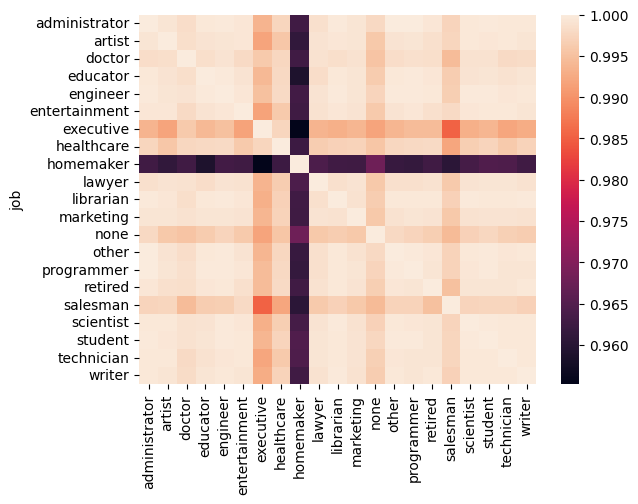

In [37]:
import seaborn as sns
sns.heatmap(job_embeddings_diffs)